# Combined Optimizations Notebook

This notebook computes parameters using all new optimizations for GEOtiled and compares it to GEOtiled's run time before optimizations.

## Preconfiguration

Import all needed libraries to run notebook.

In [1]:
import crop_functions as cp
import compute_functions as cm
import mosaic_functions as ms
import geotiled
import shutil
import time

Set the needed variables to run the tests.

Do not specify tile sizes that would cause the final file count to exceed the number of cores available for the best performance results.

In [2]:
# The working directory to store files in
working_directory = '/media/volume/geotiled-saga/optimization_test'
geotiled.set_working_directory(working_directory)

# Size of tiles to produce specified as a list of [x,y] values (units of pixels)
tile_sizes = [[18274,16862],[18274,8431],[9137,8431],[9137,4216],[4569,4216]]

# Data to download
resolution = '30m'
region = 'TN'

# Parameters to compute
parameters = ['slope','convergence_index','total_catchment_area']

# Number of runs to do (execution times for each tile size will be averaged at the end)
runs = 10

In [ ]:
# Create CSV
file = open('results.csv', 'w')
file.write('method,parameter,tile_size,run_number,execution_time\n')
file.close()

## Initialization

Download and preprocess the data.

In [ ]:
# Download the desired data
geotiled.fetch_dem(shapefile=region, dataset=resolution, save_to_txt=False, download=True)

# Mosaic DEMs
geotiled.build_mosaic(input_folder='dem_tiles', output_file='mosaic.tif', description='Elevation')

# Reproject mosaic into computable format
geotiled.reproject(input_file='mosaic.tif', output_file='elevation.tif', projection='EPSG:26918')

## Compute without Optimizations

Compute all parameters without optimizations and time it.

In [ ]:
# Compute parameters with GEOtiled before optimizations
for ts in tile_sizes:
    for param in parameters:
        for i in range(runs):
            # Crop, compute, and mosaic
            start_time = time.time()
            cp.sequential_crop('elevation.tif', 'elevation_tiles', ts[0], ts[1])
            cm.parallel_compute('elevation_tiles', [param])
            ms.mosaic_average(f"{param}_tiles", f"unoptimized_{param}.tif")
            run_time = time.time() - start_time
    
            # Update CSV
            file = open('results.csv', 'a')
            file.write(f"unoptimized,{param},{ts[0]}x{ts[1]},{i},{run_time}\n")
            file.close()

## Compute with Optimizations

Compute all parameters with all new optimizations and time it.

In [ ]:
# Cleanup some old files to prevent errors with tests
shutil.rmtree('elevation_tiles')
for param in parameters:
    shutil.rmtree(f"{param}_tiles")

In [ ]:
# Compute parameters with GEOtiled before optimizations
for ts in tile_sizes:
    for param in parameters:
        for i in range(runs):
            # Crop, compute, and mosaic
            start_time = time.time()
            geotiled.crop_and_compute('elevation.tif', ts[0], ts[1], [param])
            geotiled.build_mosaic(f"unbuffered_{param}_tiles",f"optimized_{param}.tif")
            run_time = time.time() - start_time

            # Update CSV
            file = open('results.csv', 'a')
            file.write(f"optimized,{param},{ts[0]}x{ts[1]},{i},{run_time}\n")
            file.close()

## Visualize Results

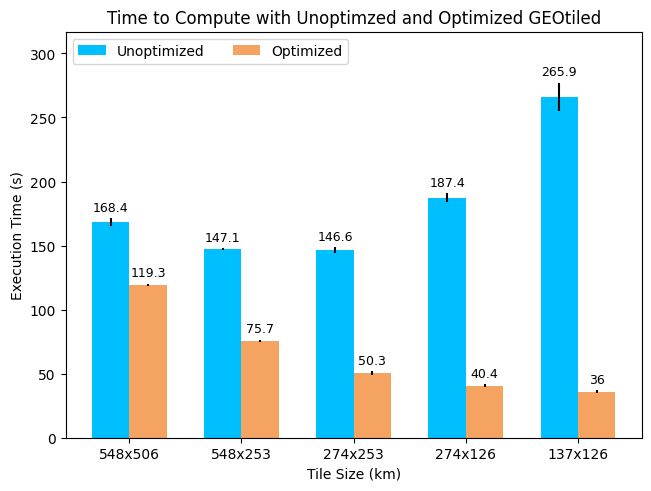

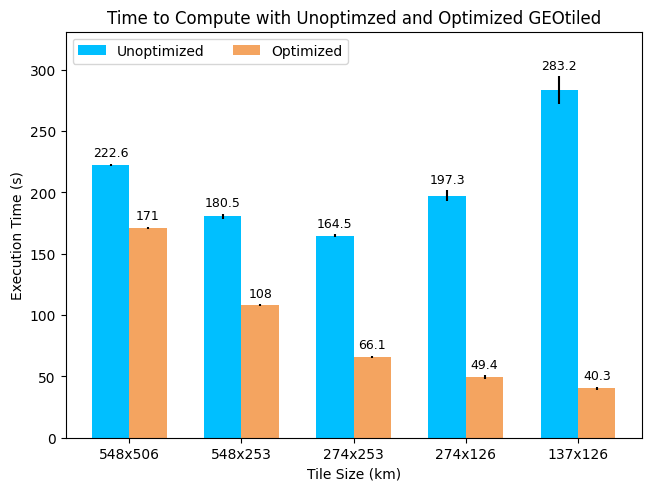

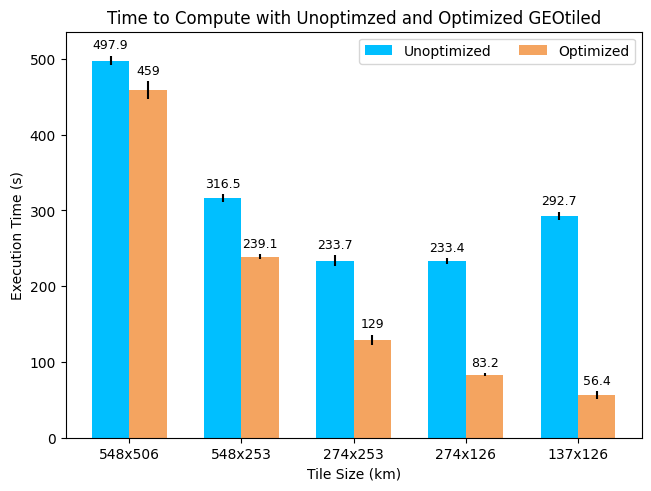

In [3]:
cm.plot_optimization_results('results.csv','slope', 'left')
cm.plot_optimization_results('results.csv','convergence_index', 'left')
cm.plot_optimization_results('results.csv','total_catchment_area', 'right')

### End of Notebook